# NLP Study: Sentiment Analysis With LSTM vs Transformer

> ## Research Question
Can LSTM and Transformer-based models produce significantly different sentiment predictions when the training data sequence is altered?

To explore this, I train each model twice:
- Once using the dataset in its original review order.
- Once using the same dataset after random shuffling.

This experiment compares performance differences to understand the effect of sequential dependency on different architectures.

---

💡 **To view the experiment results in MLflow, go to:** https://sentiment-order-lab.onrender.com  
*The server may be temporarily down due to inactivity. Please wait about ~1 minute for it to start.*

<div style="border: 2px solid crimson; padding: 10px; border-radius: 8px; background-color: #ffe6e6;">
<b>❗ Important Note:</b>  
To run this notebook, you have to click the link above and wait for it to start.
</div>


## Imports and definitions

In [24]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
import json
import ast
import mlflow
import os

#### Load statistics

In [25]:
stats_file_path = "../logs/stats.log"
stats_log = open(stats_file_path).readlines()[-1]
stats = json.loads(stats_log)

eval_file_path = "../logs/evaluation_results.log"
with open(eval_file_path, "r") as f:
    eval_logs = [json.loads(line.strip()) for line in f if line.strip()]

#### Visualization functions

In [26]:
def set_chart_style(base_color="#08519c"):
    """
    Sets global chart style using a base color.
    """
    plt.style.use('default')
    plt.rcParams.update({
        'figure.figsize': (6, 4),
        'axes.grid': True,
        'grid.color': 'lightgray',
        'grid.linestyle': '--',
        'grid.alpha': 0.7,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.edgecolor': 'gray',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.prop_cycle': plt.cycler(color=[base_color])
    })
    sns.set_style("whitegrid")
set_chart_style()

In [27]:
def get_color_gradient(base_color="#08519c", n=4):
    """
    Generate n gradient shades of the base color from light to dark.
    """
    return [mcolors.to_hex(c) for c in 
            mcolors.LinearSegmentedColormap.from_list("", ["white", base_color])(np.linspace(0.3, 1, n))]

In [28]:
def get_color_for_run(run_name, base_color="#08519c", other_color="#308613"):
    if "original" in run_name.lower():
        return base_color
    elif "shuffled" in run_name.lower():
        return other_color
    else:
        return "#999999"  # fallback gray

In [29]:
def plot_spacy_funnel(ax, stages, values, title="spaCy Pipeline Funnel", base_color="#08519c"):
    """
    Funnel chart with gradient color from bottom (bold) to top (light).
    """
    set_chart_style(base_color)
    funnel_colors = get_color_gradient(base_color, len(stages))[::-1]  # bottom = bold

    bars = ax.barh(stages, values, color=funnel_colors)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("Stage")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Annotate each bar with its count (centered)
    for bar, value in zip(bars, values):
        ax.text(value / 2,                       # horizontal center
                bar.get_y() + bar.get_height() / 2,  # vertical center
                f"{value:,}",                    # format with comma
                va='center', ha='center', color='black', fontsize=12)

In [30]:
def plot_metric_progression(experiment_data, metrics_of_interest, base_color="#08519c"):
    """
    Plots line charts showing metric progression over epochs for each experiment and run.
    """
    set_chart_style(base_color)

    for exp_name, run_metrics in experiment_data.items():
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        fig.suptitle(f"Metric Progression - {exp_name}", fontsize=16)
        axes = axes.flatten()

        for idx, metric in enumerate(metrics_of_interest):
            ax = axes[idx]
            for run_name, data in run_metrics[metric].items():
                steps, values = zip(*data)
                ax.plot(
                    steps,
                    values,
                    label=run_name,
                    color=get_color_for_run(run_name),
                    marker='o'
                )
            ax.set_title(metric.replace("_", " ").title())
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Value")
            ax.grid(True)
            ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [31]:
def plot_metric_comparison(df, metrics, group_col='Order', model_col='Model', label_col='Order',
                           color_map=None, base_color="#08519c", other_color="#308613", title="Model Performance"):
    """
    Plots grouped bar charts comparing multiple metrics (e.g., Accuracy, F1 Score)
    between original and shuffled datasets.
    """
    set_chart_style(base_color)
    
    if not color_map:
        color_map = {
            'Original': base_color,
            'Shuffled': other_color
        }

    models = df[model_col].unique()
    groups = df[group_col].unique()
    bar_width = 0.35
    
    fig, axes = plt.subplots(1, len(metrics), sharey=True, figsize=(10, 4))
    if len(metrics) == 1:
        axes = [axes]

    for ax, (metric_col, metric_label) in zip(axes, metrics):
        for i, group in enumerate(groups):
            # Align the subset to the models to avoid shape mismatch
            subset = df[df[group_col] == group].set_index(model_col).reindex(models)
            values = subset[metric_col].values

            ax.bar(
                [x + i * bar_width for x in range(len(models))],
                values,
                width=bar_width,
                label=group,
                color=color_map.get(group, base_color)
            )

        ax.set_xticks([x + bar_width / 2 for x in range(len(models))])
        ax.set_xticklabels(models)
        ax.set_title(f"{metric_label} Comparison")
        ax.set_xlabel("Model")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    axes[0].set_ylabel("Score")
    axes[-1].legend(title=label_col)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [32]:
def plot_confusion_matrices(matrices, labels, titles, from_raw_cm=False,
                           colors = ["#308613", "#b7cee6", "#5b8dbb", "#08519c"]):
    
    set_chart_style('#08519c')
    cmap = ListedColormap(colors)

    # Define boundaries between color bins
    boundaries = [0, 300, 800, 1500, float("inf")]
    norm = BoundaryNorm(boundaries, ncolors=len(colors))
    
    n = len(matrices)
    rows = (n + 1) // 2
    fig, axes = plt.subplots(rows, 2, sharex=True, sharey=True, figsize=(10, 4))
    axes = axes.flatten()

    for i, (item, title) in enumerate(zip(matrices, titles)):
        cm = item if from_raw_cm else confusion_matrix(*item, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, norm=norm, cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i],
                    linewidths=0.5, linecolor='white', annot_kws={"size": 12})
        axes[i].set_title(title)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [33]:
%%html
<style>
  table {float: left;}             /* forces the table to the left */
  table {margin-left: 0 !important;} /* alternative approach */
</style>

## 1. Dataset Selection
**This study uses a 20K sample subset of the IMDb Movie Reviews dataset**.
Each review is labeled as either `positive` or `negative`, providing a balanced and reliable foundation for evaluating sentiment classification models.

### Data Splitting
The dataset is divided into three standard subsets:
- **Training Set**: Used to fit the model.
- **Validation Set**: Used to tune model hyperparameters and monitor for overfitting.
- **Test Set**: Unseen data used for final evaluation.

The class distribution is **approximately balanced**, helping prevent model bias toward either class.

In [34]:
imdb_df = pd.read_csv("../data/IMDB_Dataset_medium.csv")
imdb_df['label'] = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
print(imdb_df['sentiment'].value_counts())
imdb_df.head()

sentiment
negative    10097
positive     9903
Name: count, dtype: int64


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


## 2-4. Tokenizer, Lemmatizer and Tagger
For this core steps I'll use **spaCy**. I'ts important to mention that the output of this step will only be useful for the LSTM model, since TinyBERT works better with raw and untokenized text.

### Why Lemmas for LSTM?  
Lemmas are used instead of raw tokens for the LSTM model to reduce vocabulary size and eliminate inflected word variants (e.g., “run” vs. “running”). This improves generalization and reduces noise for models trained from scratch like LSTM.

### Why Raw for TinyBERT?  
Pre-trained transformer models like TinyBERT expect raw text and rely on their internal tokenization strategies (like WordPiece), since they are robust to vocabulary richness due to subword tokenization. Lemmatizing or altering the text may harm the learned contextual embeddings.

#### Word count reduction by parsing stages

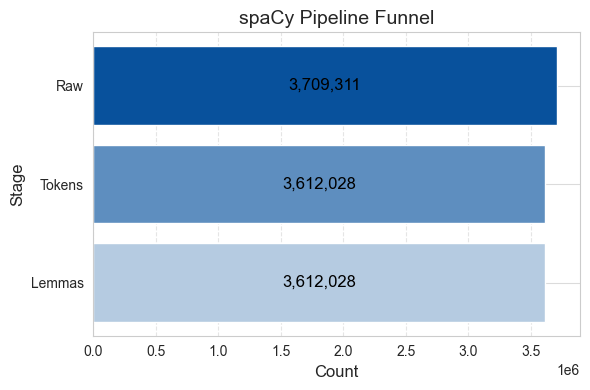

In [35]:
stages = ['Raw', 'Tokens', 'Lemmas']
values = [stats['raw'], stats['tokens'], stats['lemmas']]

set_chart_style("#08519c")
fig, ax = plt.subplots(figsize=(6, 4))
plot_spacy_funnel(ax, stages, values)
plt.tight_layout()
plt.show()

#### Top 10 of POS tags

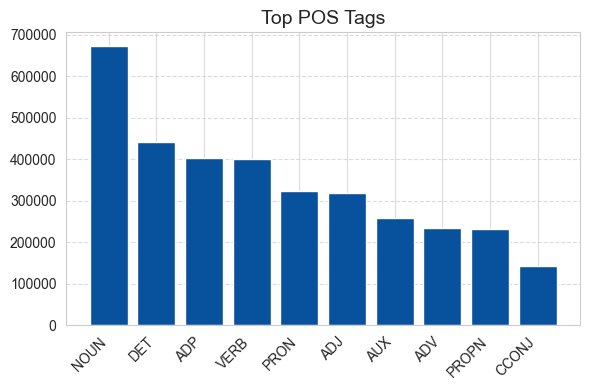

In [36]:
pos_counts = stats['pos_count']
labels = list(pos_counts.keys())
counts = list(pos_counts.values())

plt.figure()
plt.bar(labels, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top POS Tags")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### Distribution of token lenghts
To better understand the typical length of tokenized reviews in the dataset, I analyzed their distribution. This helps determine an appropriate **padding length before model training**. This step is crucial because the chosen padding length directly impacts the input representation used during model training.

The best choice was to preserve around 85% of the data with a maximum sequence length (`max_len`) of 400.  
However, due to resource limitations, **the maximum sequence length was set to 200**.

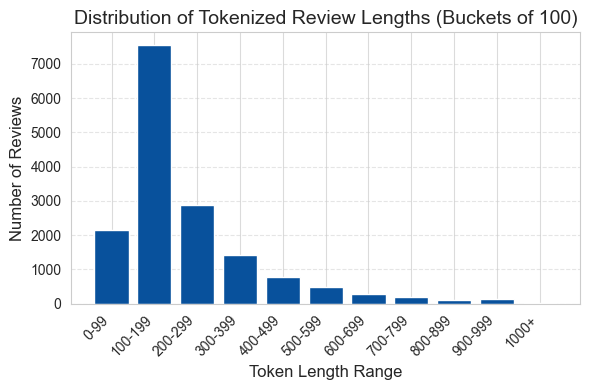

In [37]:
len_buckets = stats["len_buckets"]
bucket_labels = list(len_buckets.keys())
bucket_values = list(len_buckets.values())

# Plot
plt.bar(bucket_labels, bucket_values)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Tokenized Review Lengths (Buckets of 100)")
plt.xlabel("Token Length Range")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5. Word Embedding with Word2Vec
To convert raw textual data into a numerical format understandable by neural networks, we used Word2Vec embeddings.
Word2Vec captures semantic meaning by placing similar words close together in a continuous vector space.

I trained the Word2Vec model on the **lemmatized tokens** of the training dataset. This ensures reduced vocabulary size while preserving word meaning. The resulting word vectors were used to build an embedding matrix, which was then loaded into the first layer of the LSTM model.

#### 📌 Training Parameters:
- vector_size: 100
- window: 5
- min_count: 2
- workers: 4


## 6. Sentiment Analysis with LSTM (Long Short Term Memory)
LSTM (Long Short-Term Memory) processes input sequentially, making it **sensitive to the order of input**.  

**Why Order Matters?** LSTMs are time-series models. They learns by remembering sequences, meaning earlier inputs affect future states.  
Shuffling disrupts the temporal patterns they rely on.

#### Model Pipeline
* **Input**: Lemmatized text with Word2Vec embeddings, since they work well together.
* **Architecture**:
    * Embedding Layer (pre-trained Word2Vec, non-trainable)
    * LSTM Layer (64 units, with dropout and recurrent dropout)
    * Dense Output Layer (Sigmoid activation) 
* **Output**: Binary classification via Sigmoid  

## 7. Sentiment Analysis with TinyBERT (Transformer)
Transformers use self-attention and positional encodings to process all tokens in parallel. This makes them **less sensitive to training data order**.  

**Model Choice**: Used TinyBERT (faster, lower memory) instead of DistilBERT.  
**Why Order Matters Less?** Transformers don't rely on previous hidden states. They learn dependencies regardless of position (with help from position embeddings).

#### Model Pipeline
* **Model**: Pre-trained Transformer Encoder (TinyBERT General 4L 312D)  
* **Input**: Untouched raw sentences (tokenized via tokenizer)
* **Architecture**:
    * Pre-trained Transformer Encoder (TinyBERT General 4L 312D)
    * Dropout Layer
    * Classification Head (Dense Layer) 
* **Output**: Softmax binary classifier



## 8-9. Train Both Models: Original vs Shuffled

This section compares how sentence order affects learning behavior during training and validation.  
Training was performed in two phases:

1. **Original order**
2. **Shuffled order**

### 📌 Training observations
**LSTM – Original vs. Shuffled**  
The LSTM model trained on **original order converged faster and achieved higher validation accuracy📈** and lower validation loss compared to its shuffled counterpart. This suggests that preserving the original example order helps the LSTM exploit sequential patterns across training examples. In contrast, training on the **shuffled version resulted in unstable training and lower generalization**, highlighting the model’s sensitivity to the order in which training data is presented.

**TinyBERT – Original vs. Shuffled**  
TinyBERT’s **performance was relatively stable between the two orders**. Training and validation metrics showed minimal decline when using the shuffled version. This reinforces that TinyBERT captures contextual dependencies internally, **making it more robust to shuffling**.

### 📌 Training parameters

| Parameter         | LSTM                                      | TinyBERT                                           |
|-------------------|-------------------------------------------|----------------------------------------------------|
| **Framework**     | Keras (TensorFlow)                        | PyTorch (Hugging Face Transformers)                |
| **Tokenizer**     | Keras Tokenizer                           | BertTokenizerFast                                  |
| **Epochs**        | 10                                        | 5                                                  |
| **Batch Size**    | 64                                        | 64                                                 |
| **Optimizer**     | Adam                                      | AdamW                                              |
| **Learning Rate** | 0.001                                     | 2e-5                                               |
| **Loss Function** | Binary Crossentropy                       | Built-in                                           |
| **Early Stopping**| Enabled                                   | Disabled                                           |


#### Collect training results (mlflow metrics)

In [38]:
mlruns_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'mlruns'))
mlflow.set_tracking_uri('https://sentiment-order-lab.onrender.com/')
client = mlflow.tracking.MlflowClient()

experiments = ['LSTM_sentiment_experiment', 'TinyBERT_sentiment_experiment']
metrics_of_interest = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
experiment_data = {}

In [39]:
for exp_name in experiments:
    exp = client.get_experiment_by_name(exp_name)
    runs = client.search_runs(
        experiment_ids=[exp.experiment_id],
        order_by=["start_time ASC"]
    )

    run_metrics = defaultdict(lambda: defaultdict(list))

    for run in runs:
        run_id = run.info.run_id
        run_name = run.data.tags.get('mlflow.runName', 'Unnamed Run')

        for metric in metrics_of_interest:
            history = client.get_metric_history(run_id, metric)
            if history:
                history.sort(key=lambda x: x.step)
                run_metrics[metric][run_name] = [(m.step, m.value) for m in history]

    experiment_data[exp_name] = run_metrics

### Plot training results

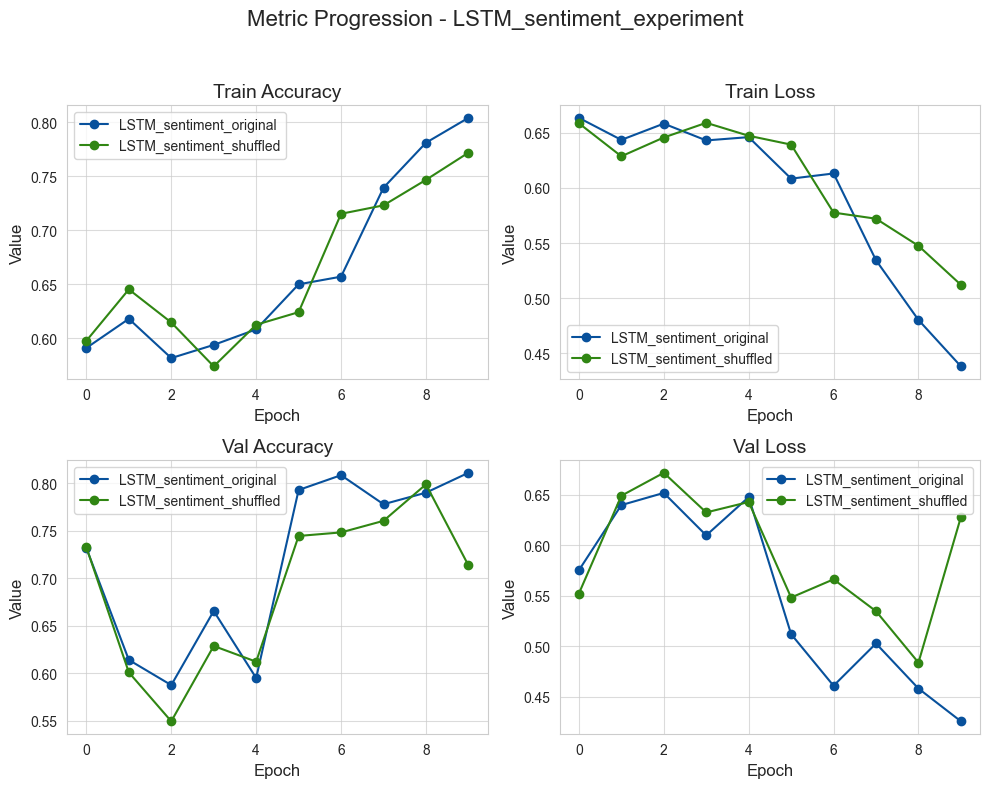

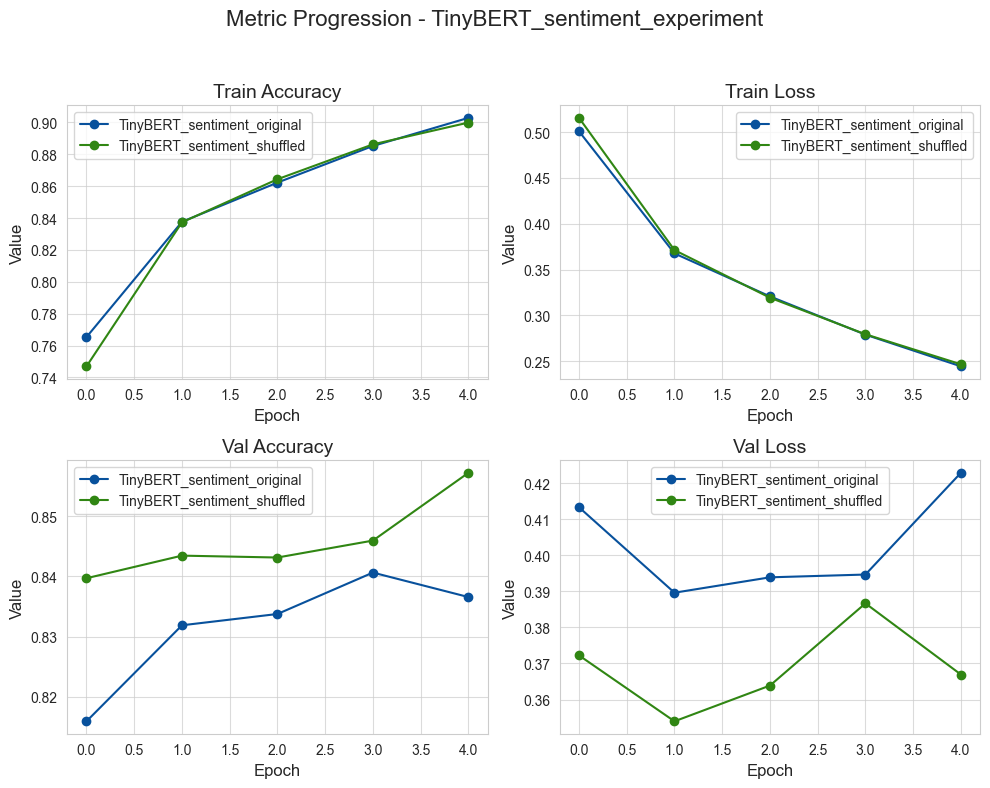

In [40]:
plot_metric_progression(
    experiment_data=experiment_data,
    metrics_of_interest=metrics_of_interest,
    base_color="#08519c"
)

## 10. Evaluation Metrics
The evaluation charts illustrate how the order of input affects final test performance. **LSTM is clearly impacted by shuffling, while TinyBERT remains mostly stable**.  
I'll evaluate the models using the following: **Accuracy**, **F1 Score** and **Confusion Matrix**.

### Accuracy & F1 Score
**LSTM**
In both Accuracy and F1 Score you can see that the trained model on the original dataset order has a higher score📈, in contrast to the shuffled model which has lower score📉 in both evaluations.  
**TinyBERT**
Both Accuracy and F1 Score remain high regardless of the training order, indicating that TinyBERT is not significantly affected by whether the data is ordered or shuffled.

### Confusion Matrix

**LSTM** shows strong performance on the original order with low false negatives (FN), but when shuffled, FN jumps from 190 to 🔺1000 — a major drop in its ability to detect positive sentiment, despite a high true negative (TN) count.  
**TinyBERT**, however, stays more stable across both settings, with a small increase in false positives (FP) and a decrease in FN, showing only a minor shift in error patterns. This backs up the fact that TinyBERT is less affected by changes in training order.

#### Process metrics

In [41]:
# Extract confusion matrix components
def extract_confusion_parts(matrix):
    tn, fp = matrix[0]
    fn, tp = matrix[1]
    return pd.Series({'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

In [42]:
eval_df = pd.DataFrame(eval_logs)
eval_df['Accuracy'] = (eval_df['test_accuracy'] * 100).round(2).astype(float) / 100
eval_df['F1 Score'] = eval_df['f1_score'].round(4)
eval_df['Model'] = eval_df['model_name'].apply(lambda name: 'LSTM' if 'LSTM' in name else 'TinyBERT')
eval_df['Order'] = eval_df['model_name'].apply(lambda name: 'Original' if 'original' in name else 'Shuffled')

eval_df['confusion_matrix'] = eval_df['confusion_matrix'].apply(ast.literal_eval)

conf_matrix_parts = eval_df['confusion_matrix'].apply(extract_confusion_parts)
eval_df = pd.concat([eval_df, conf_matrix_parts], axis=1)
evaluation = eval_df[['Model', 'Order', 'Accuracy', 'F1 Score', 'TP', 'FP', 'FN', 'TN']]


In [43]:
model_types = ['LSTM', 'TinyBERT']
orders = ['Original', 'Shuffled']

matrices = []
titles = []

for model in model_types:
    for order in orders:
        row = eval_df[(eval_df['Model'] == model) & (eval_df['Order'] == order)].iloc[0]
        matrices.append(row['confusion_matrix'])
        titles.append(f"{model} - {order}")

### Plot evaluation metrics

In [44]:
evaluation

,Model,Order,Accuracy,F1 Score,TP,FP,FN,TN
0,LSTM,Original,0.8062,0.8197,1762,585,190,1463
1,LSTM,Shuffled,0.7270,0.6355,952,92,1000,1956
2,TinyBERT,Original,0.8465,0.8319,1519,181,433,1867
3,TinyBERT,Shuffled,0.8502,0.8444,1625,272,327,1776


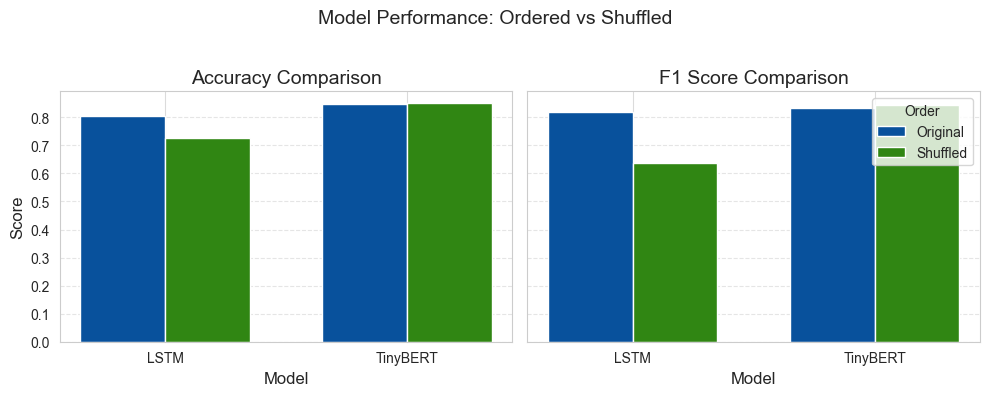

In [45]:
plot_metric_comparison(
    df=eval_df,
    metrics=[('Accuracy', 'Accuracy'), ('F1 Score', 'F1 Score')],
    base_color="#08519c",
    title="Model Performance: Ordered vs Shuffled"
)

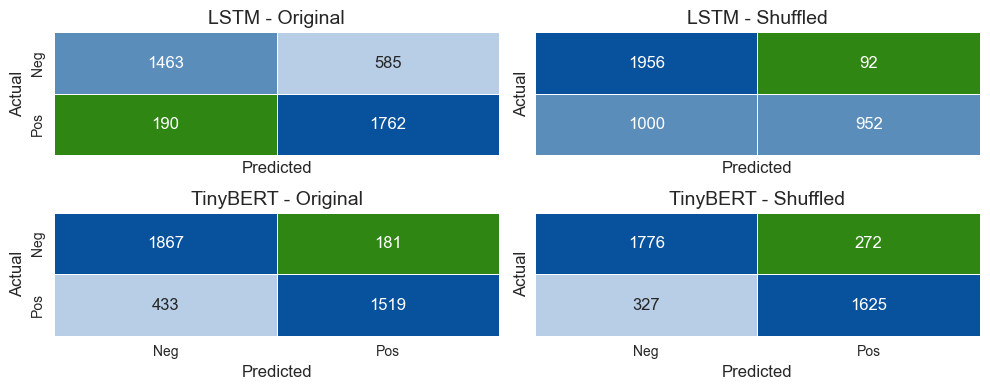

In [46]:
plot_confusion_matrices(
    matrices=matrices,
    labels=['Neg', 'Pos'],
    titles=titles,
    from_raw_cm=True
)

## 11. Results & Comparison

The study reveals a clear distinction between how LSTM and TinyBERT handle the ordering of training data.

**LSTM performance drops when trained on shuffled data** — accuracy falls from 80% with the original order to 🔻72% when shuffled. This decline is also reflected in the F1 score and a sharp rise in false negatives. This confirms that LSTM, which relies on sequential processing, is **highly sensitive to input order**.  
In contrast, **TinyBERT maintains consistent performance**, achieving **85% accuracy** in both ordered and shuffled training scenarios. This indicates that TinyBERT’s attention-based architecture is better at capturing global context, making it **less sensitive to the order of input order**.

> 💡 **Key insight**: Models like LSTM are significantly influenced by training data order, whereas transformer models like TinyBERT remain robust even when the input order is changed.

## References
- IMDB Reviews dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- MLFlow documentation: https://mlflow.org/docs/latest/api_reference/python_api/mlflow.html
- TensorFlow documentation: https://www.tensorflow.org/guide/keras/functional_api